In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from tqdm import trange
import pandas as pd
pd.set_option('expand_frame_repr', False)
from matplotlib.ticker import FormatStrFormatter  
sns.set(font_scale=2)
import sys
import json
import os
import re
from scipy.stats import pearsonr
import pickle

## Util

In [4]:
dataset_name = ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Traffic', 'Electricity','ILI', 'Solar Hour', 'Solar 10min', 'River Flow', 'Sunspot']
datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','illness_ltsf','sunspot', 'solar_hour', 'solar_10min','river_flow']
def replace_dataset_name(df):
    df['dataset'] = df['dataset'].replace('ettm1', 'ETTm1', regex=True) 
    df['dataset'] = df['dataset'].replace('ettm2', 'ETTm2', regex=True) 
    df['dataset'] = df['dataset'].replace('etth1', 'ETTh1', regex=True) 
    df['dataset'] = df['dataset'].replace('etth2', 'ETTh2', regex=True) 
    df['dataset'] = df['dataset'].replace('exchange_ltsf', 'Exchange', regex=True) 
    df['dataset'] = df['dataset'].replace('weather_ltsf', 'Weather', regex=True) 
    df['dataset'] = df['dataset'].replace('traffic_ltsf', 'Traffic', regex=True) 
    df['dataset'] = df['dataset'].replace('electricity_ltsf', 'Electricity', regex=True) 
    df['dataset'] = df['dataset'].replace('illness_ltsf', 'ILI', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_hour', 'Solar Hour', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_10min', 'Solar 10min', regex=True) 
    df['dataset'] = df['dataset'].replace('river_flow', 'River Flow', regex=True) 
    df['dataset'] = df['dataset'].replace('sunspot', 'Sunspot', regex=True) 
    return df

def sort_order(cat_res, sort_order_dict=None, inf_sort_order=False):
    # cat_res = cat_res.loc[cat_res['Infer hor.'] != '24']
    
    # inf_sort_order = ['48', '60', '96', '192', '336', '720', '1024']
    if inf_sort_order:
        inf_sort_order = ['24', '48', '96', '192','336', '720', '1024']
        cat_res['Infer hor.'] = pd.Categorical(cat_res['Infer hor.'], categories=inf_sort_order, ordered=True)
        cat_res = cat_res.sort_values(by='Infer hor.')
    
    if sort_order_dict is not None:
        for key, value in sort_order_dict.items():
            cat_res[key] = pd.Categorical(cat_res[key], categories=value, ordered=True)
            cat_res = cat_res.sort_values(by=key)
    
    return cat_res

def filed_filter(df, fileds_dict, eq=True):
    for key, values in fileds_dict.items():
        if eq:
            df = df[df[key].isin(values)]
        else:
            df = df[~df[key].isin(values)]
                
    return df

def add_spec_setting(res_dict, prefix=''):
    datasets = []
    infer_hor = []
    train_hor = []
    val_hor = []
    ND = []
    NRMSE = []
    seed = []
    for dataset in ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Electricity','Traffic', 'Solar Hour', 'Solar 10min', 'River Flow', 'Sunspot']:
        for hor in ['96', '192', '336', '720']:
            try: 
                ND.append(res_dict[(res_dict['val_len']==hor) & (res_dict['Infer hor.']==hor) & (res_dict['Train hor.']==hor) & (res_dict['dataset']==dataset)]['ND'].values[0])
                NRMSE.append(res_dict[(res_dict['val_len']==hor) & (res_dict['Infer hor.']==hor) & (res_dict['Train hor.']==hor) & (res_dict['dataset']==dataset)]['NRMSE'].values[0])
                datasets.append(dataset)
                infer_hor.append(hor)
                train_hor.append(prefix+'spec')
                val_hor.append(prefix+'spec')
                seed.append(0)
            except:
                continue
            
    res_dict = {"dataset": datasets, "Infer hor.": infer_hor, "Train hor.": train_hor, "val_len": val_hor, "ND": ND , "NRMSE": NRMSE, "seeds": seed,}
    return pd.DataFrame(res_dict)

def plot_multi_marked_line(res,  x,  y, hue=None, style=None, title=None, datasets=['ETTh1'],save_name=None,line_styles=False, 
                           line_style_list=None,errorbar=None, palette=None, data_char=None, axvline=None,axhline=None, axhline_label=None,
                           hight=5, width=6, x_min=None, x_max=None, all_in_one=False, font_scale=1.5):
    sns.set(font_scale=font_scale)
    sub_num = len(datasets)
    if palette:
        sns.set_palette(palette)
    if sub_num > 1 and not all_in_one:
        plt.figure()
        total_len = sub_num * width
        fig, ax = plt.subplots(1, sub_num,figsize=(total_len, hight))  
        legend = False
        for i in range(sub_num):
            if line_style_list is not None:
                local_line_style = line_style_list[i]
            else:
                local_line_style = line_styles
                
            if datasets[i] == 'ETT':
                sub_res = res[(res['dataset']=='ETTm1') | (res['dataset']=='ETTm2') | (res['dataset']=='ETTh1') | (res['dataset']=='ETTh2')]
            else:
                sub_res = res[res['dataset']==datasets[i]]
                
            if i == (sub_num-1):
                legend = True
            sns.lineplot(
                data=sub_res, legend=legend,
                x=x, y=y, hue=hue, style=style, ax=ax[i], errorbar=errorbar,
                markers=True, dashes=local_line_style, linewidth=2,markersize=10
            )
            if axvline is not None:
                ax[i].axvline(x=axvline, color='r', linestyle='--', linewidth=2,markersize=10) 
            ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            
            if data_char is not None:
                season = data_char[datasets[i]]['Seasonality']
                trend = data_char[datasets[i]]['Trend']
                data_char_str = f'\nFs:{season} Ft:{trend}'
            else:
                data_char_str = ''
            ax[i].set_title(f'{datasets[i]}{data_char_str}')  
            ax[i].tick_params(axis='y', labelsize=15)    
            ax[i].tick_params(axis='x', labelsize=16)    
            if i > 0:
                ax[i].set_ylabel('')
                
        if title is not None:
            fig.suptitle(title)
    else:
        plt.figure(figsize=(width, hight))
        if datasets[0] == 'ETT':
            sub_res = res[(res['dataset']=='ETTm1') | (res['dataset']=='ETTm2') | (res['dataset']=='ETTh1') | (res['dataset']=='ETTh2')]
        else:
            # sub_res = res[res['dataset']==datasets[0]]
            sub_res = res[res['dataset'].isin(datasets)]
        sns.lineplot(
            data=sub_res,
            x=x, 
            y=y, 
            hue=hue, style=style, errorbar=None,
            markers=True, dashes=line_styles, linewidth=2, markersize=10
        )
        if axvline is not None:
            plt.axvline(x=axvline, color='r', linestyle='--', linewidth=2,markersize=10) 
            
        if axhline is not None:
            plt.axhline(y=axhline, color='gray', linestyle='--', linewidth=2, label=axhline_label)
        
        if x_min is not None:
            plt.xlim(x_min, x_max)
            
        if title is not None:
            plt.title(title)
    
    # plt.legend(title=hue, loc='upper left', bbox_to_anchor=(1, 1))  
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1),title=hue)  
    plt.tight_layout() 
    if save_name is not None:
        plt.savefig(f'fig/{save_name}.svg', format='svg') 

## Load data

In [5]:
def load_result(root_dir, verbose=True, models=['PatchTST'], train_pred_len_list=['24','36','48','60','96','192','336','720'], train_context_list=['36','96'], datasets=None):
    NRMSE = []
    ND = []
    CRPS = []
    train_pred_len_lists = []
    dataset_list = []
    seeds = []
    train_ctx = []
    model_list = []
    if datasets is None:
        datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']

    seed=0
    
    for dataset in datasets:
        for model in models:
            for train_pred_len in train_pred_len_list:
                for train_context in train_context_list:
                    csv_file = root_dir + f"{dataset}_{train_context}_{train_pred_len}_{model}_{seed}/test/metrics.csv"
                    try:
                        data = pd.read_csv(csv_file)
                    except:
                        if verbose:
                            print("cannot find ", csv_file) 
                        continue
                    
                    for idx in range(len(data)):
                        NRMSE.append(data['test_NRMSE'][idx])
                        ND.append(data['test_ND'][idx])
                        CRPS.append(data['test_CRPS'][idx])

                        dataset_list.append(dataset)
                        model_str = model
                        train_pred_len_lists.append(train_pred_len)
                        train_ctx.append(train_context)
                        model_list.append(model_str)
                        seeds.append(seed)

    res_dict = {"dataset": dataset_list, "pred hor.": train_pred_len_lists, "ND":ND , "NRMSE": NRMSE, 'CRPS':CRPS, "seeds": seeds,
                "model": model_list,'train_ctx': train_ctx}

    return pd.DataFrame(res_dict)


# ReVIN

## long

In [6]:
# PatchTST

datasets=None
root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_false/logs/"
norm_false_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_false_res['scaling'] = 'false'
norm_false_res['revin'] = 'false'

root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_true/logs/"
norm_true_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_true_res['scaling'] = 'false'
norm_true_res['revin'] = 'true'

root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_temp/logs/"
norm_temp_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_temp_res['scaling'] = 'true'
norm_temp_res['revin'] = 'false'

patchtst_res= pd.concat([norm_false_res, norm_true_res, norm_temp_res], ignore_index=True)
patchtst_res['scaler'] = 'standard'

In [75]:
def get_df_results(root_path, models,datasets=None,verbose=False):
    combined_df = pd.DataFrame()
    # if datasets is None:
    #     datasets = ['etth1','''exchange_ltsf','weather_ltsf','traffic_ltsf','electricity_ltsf','illness_ltsf']
    for scaler in ['identity', 'standard']:
        for revin in ['true', 'false']:
            for scaling in ['false', 'true']:
                norm_res = load_result(root_dir = f"{root_path}{scaler}_revin_{revin}_scaling_{scaling}/logs/", verbose=verbose, models=models, datasets=datasets)
                norm_res['scaler'] = scaler
                norm_res['revin'] = revin
                norm_res['scaling'] = scaling
                combined_df = pd.concat([combined_df, norm_res], ignore_index=True)
    return combined_df

In [74]:
gru_nvp_res = get_df_results('/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_norm/', ['GRU_NVP'])
csdi_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['CSDI'])
timegrad_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['TimeGrad'])
gru_res = get_df_results('/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_norm/', ['GRUForecaster'])
patchtst_ili_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['PatchTST'],datasets=['illness_ltsf'])
gru_nvp_ili_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['GRU_NVP'],datasets=['illness_ltsf'])

combined_df = pd.concat([patchtst_res, patchtst_ili_res, gru_nvp_res, gru_nvp_ili_res, csdi_res, timegrad_res, gru_res], ignore_index=True)

In [76]:
def reformat(res_dict):
    datasets = []
    pred_hor = []
    norm = []
    ND = []
    CRPS = []
    seed = []
    global_norm = []
    model = []
    for index, row in res_dict.iterrows():
        if row['revin'] == 'true' and row['scaling'] == 'false':
            norm.append('ReVIN')
        elif row['revin'] == 'false' and row['scaling'] == 'true':
            norm.append('Scaling')
        elif row['revin'] == 'false' and row['scaling'] == 'false':
            norm.append('None')
        else:
            continue
        
        datasets.append(row['dataset'])
        pred_hor.append(row['pred hor.'])
        ND.append(row['ND'])
        global_norm.append(row['scaler'])
        CRPS.append(row['CRPS'])
        model.append(row['model'])
        
            
    res_dict = {'model': model, "dataset": datasets, "gobal norm": global_norm, "pred hor.": pred_hor, "CRPS": CRPS, "ND": ND , "norm": norm}
    return pd.DataFrame(res_dict)

In [77]:
norm_res = reformat(combined_df)
norm_res = replace_dataset_name(norm_res)

sort_order_dict = {'pred hor.': ['24','36','48','60','96','192','336','720'], 'model': ['PatchTST', 'CSDI','TimeGrad', 'GRU_NVP','GRUForecaster'], 'norm': ['ReVIN', 'Scaling','None']}
sort_norm_res = sort_order(norm_res, sort_order_dict=sort_order_dict)

In [78]:
# sort_norm_res['CRPS/ND'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.3f}/{x['ND']:.3f}", axis=1)
sort_norm_res['ND'] = sort_norm_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_norm_res['CRPS'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

sort_norm_res = sort_norm_res[sort_norm_res["gobal norm"]=='standard']

In [79]:
# Create a pivot table
pivot_table = pd.pivot_table(
    sort_norm_res,
    values=['CRPS'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'norm'],
    aggfunc=lambda x: x.iloc[0],
    observed=False
)

def to_markdown(pivot_table):
    pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
    pivot_table = pivot_table.reset_index()
    pivot_table_formatted_md = pivot_table.to_markdown()
    return pivot_table_formatted_md

In [80]:
import re

def mark_best_value(data):
    # 切分数据到行
    lines = data.strip().split('\n')

    # 准备新的表格内容
    new_lines = []
    count = 0
    for line in lines:
        if 'dataset' in line or "tabular" in line or 'rule' in line or 'multicolumn' in line or 'norm' in line:
            new_lines.append(line)  # 添加标题行
            continue
        
        if 'cline' in line:
            continue
        
        pattern = r"\b\d+\.\d{2,4}\b|NaN"
        values = re.findall(pattern, line)

        def mark_values(value_list, marker='bold'):
            
            numeric_values = []
            for v in value_list:
                if v != '-' and v != 'NaN':
                    numeric_values.append(float(v.split('_')[0]))
                else:
                    numeric_values.append(1000)

            # 排序获取索引
            sorted_indices = sorted(range(len(numeric_values)), key=lambda k: numeric_values[k], reverse=False)
            
            # 处理相同最小值的情况
            min_val = numeric_values[sorted_indices[0]]
            min_count = numeric_values.count(min_val)
            
            # 标记最小值
            for i in range(min_count):
                if marker=='bold':
                    value_list[sorted_indices[i]] = r'\bm{' + value_list[sorted_indices[i]] + '}'
                else:
                    value_list[sorted_indices[i]] = r'\underline{' + value_list[sorted_indices[i]] + '}'

            return value_list

        marked_values = [None]*len(values)
        for i in range(0, len(values), 3):
            marked_values[i:i+3] = mark_values(values[i:i+3],marker='bold')
            
        numeric_values = [float(re.search(r'(\d+\.\d+)', v).group(1)) for v in marked_values if re.search(r'(\d+\.\d+)', v)]
        min_value = min(numeric_values)
        
        def add_underline(value, min_value):
            matched_value = re.search(r'(\d+\.\d+)', value)
            if matched_value:
                if float(min_value) == float(matched_value.group(1)):
                    value = r'\underline{' + value + '}'
            return value
        
        updated_values = [add_underline(v, min_value) for v in marked_values]
        
        # 构造新行
        new_line_parts = line.split('&')
        new_line_parts[2:] = [' $' + v + '$' for v in updated_values]
        new_line = ' & '.join(new_line_parts) + ' \\\\ '
        
        new_line = new_line.replace('_{0.', '_{.')
        new_line = new_line.replace('\multirow[t]', '\multirow[c]')
        new_line = new_line.replace('$NaN$', '-')
        new_line = new_line.replace('$\\bm{NaN}$', '-')
        new_lines.append(new_line)
        
        if '&  720  &' in new_line or '&  60  &' in new_line:
            new_lines.append('\midrule')

    # 将新的行合并成最终的表格
    final_table = '\n'.join(new_lines)
    print(final_table)

In [87]:
# print(pivot_table_formatted_md)
pivot_table

CRPS                                                                                                                        
model                 PatchTST                     CSDI                 TimeGrad                 GRU_NVP                 GRUForecaster                
norm                     ReVIN Scaling    None    ReVIN Scaling    None    ReVIN Scaling    None   ReVIN Scaling    None         ReVIN Scaling    None
dataset     pred hor.                                                                                                                                 
ETTh1       96          0.3212  0.3437  0.3447   0.2764  0.3630  0.3671   0.2958  0.6963  0.5434  0.2771  0.5946  0.4444        0.4457  0.9734  0.5090
            192         0.3562  0.3943  0.3785   0.3553  0.4352  0.4673   0.3119  0.6410  0.5698  0.3076  0.4729  0.5056        0.4763  1.0658  0.5915
            336         0.3737  0.4213  0.4099   0.3614  0.4192  0.4814   0.3950  0.6586  0.6192  0.3081  0.6240  0.4803        0.4998  1.1416  0.5956
            720         0.3909  0.4881  0.4648   0.3960  0.4283  0.5609   0.3435  0.8670  0.5837  0.3641  0.7295  0.5862        0.5901  1.2715  0.7265
ETTh2       96             NaN     NaN     NaN   0.1446  0.1590  0.1681      NaN     NaN     NaN     NaN     NaN     NaN        0.2913  0.5277  0.8732
            192            NaN     NaN     NaN   0.1734  0.1983  0.2078   0.1905     NaN     NaN     NaN     NaN     NaN        0.3334  0.5329  0.9771
            336            NaN     NaN     NaN   0.2094  0.2124  0.2728      NaN     NaN     NaN     NaN     NaN     NaN        0.3658  0.5879  0.7353
            720            NaN     NaN     NaN   0.2054  0.2512  0.3062   0.2198     NaN     NaN     NaN     NaN     NaN        0.3594  0.6519  1.0921
ETTm1       96             NaN     NaN     NaN   0.2255  0.2597  0.2569      NaN     NaN     NaN     NaN     NaN     NaN        0.4411  0.9213  0.4433
            192            NaN     NaN     NaN   0.3313  0.3495  0.3280      NaN     NaN     NaN     NaN     NaN     NaN        0.4824  0.9978  0.6205
            336            NaN     NaN     NaN      NaN  0.4120  0.3663      NaN     NaN     NaN     NaN     NaN     NaN        0.4879  1.0089  0.6186
            720            NaN     NaN     NaN   0.3789  0.4367  0.3933      NaN     NaN     NaN     NaN     NaN     NaN        0.4941  1.0310  0.7808
ETTm2       96             NaN     NaN     NaN      NaN  0.1340  0.1314      NaN     NaN     NaN     NaN     NaN     NaN        0.1802  0.4339  0.4133
            192            NaN     NaN     NaN   0.1386     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN        0.2074  0.4159  0.5699
            336            NaN     NaN     NaN   0.1592     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN        0.2216  0.4764  0.7246
            720            NaN     NaN     NaN      NaN     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN        0.3022  0.5101  0.6574
Electricity 96          0.0857  0.0867  0.0848   0.0761  0.0735  0.0735   0.0771  0.0904  0.0961  0.0805  0.0882  0.0923        0.2261  0.1462  0.1218
            192         0.0912  0.0918  0.0910   0.2749  0.2584  0.2475   0.0806  0.0936  0.0980  0.0833  0.0945  0.0935        0.2381  0.1851  0.1299
            336         0.1001  0.1005  0.1006   0.2346  0.2835  0.3136   0.0905  0.1002  0.1125  0.0925  0.0932  0.0982        0.2807  0.2405  0.1364
            720         0.1160  0.1187  0.1178  25.7527  0.2945  0.2667   0.1164  0.0957  0.1096  0.1107  0.1036  0.1065        0.3228  0.2340  0.1455
Exchange    96          0.0235  0.0254  0.0299   0.0216  0.0210  0.0343   0.0279  0.0478  0.0837  0.0246  0.0559  0.0605        0.0385  0.1539  0.0737
            192         0.0336  0.0365  0.0404   0.0383  0.0388  0.0418   0.0364  0.0743  0.0638  0.0340  0.0814  0.0860        0.0486  0.1704  0.0858
            336         0.0462  0.0532  0.0597   0.0508  0.0485  0.0510   0.0510  0.1142  0.1030  0.

In [24]:
latex_code = pivot_table.to_latex(multicolumn=True, multirow=True)

In [ ]:
mark_best_value(latex_code)

## Plot scatter

In [96]:
def get_gap_dict(data, metrics='CRPS'):
    data_char = pd.read_csv("./exp_res/data_char.csv",index_col='Data Characteristic')
    custom_palette = {
        "NAR": (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),  # 蓝色
        "AR": (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),  # 橙色
    }
    
    datasets = []
    horizons = []
    models = []
    score_gap_list = []
    dec_scheme = []
    revin_score = []
    seasonality = []
    trend = []
    for model in ['CSDI','PatchTST', 'TimeGrad','GRU_NVP', 'GRUForecaster']:
        for idx in pivot_table.index:
            if pivot_table[metrics][model]['ReVIN'][idx] == 'NaN':
                continue
            score_gap = float(pivot_table[metrics][model]['ReVIN'][idx]) - float(pivot_table[metrics][model]['None'][idx])
            datasets.append(idx[0])
            horizons.append(idx[1])
            models.append(model)
            seasonality.append(data_char.loc['Seasonality'][idx[0]+'-L'])
            trend.append(data_char.loc['Trend'][idx[0]+'-L'])
            revin_score.append(float(pivot_table[metrics][model]['ReVIN'][idx]))
            if model in ['TimeGrad','GRU_NVP', 'GRUForecaster']:
                dec_scheme.append('AR')
            else:
                dec_scheme.append('NAR')
            score_gap_list.append(score_gap)
            
    score_gap_dict = {'dataset': datasets, 'Gap': score_gap_list, 'Horizon': horizons, 'Model': models, 'Type': dec_scheme, metrics: revin_score, 'Seasonality': seasonality, 'Trend': trend}

    gap_pd = pd.DataFrame(score_gap_dict)
    return gap_pd
    

In [82]:
def plot_norm_scatter(gap_dict, x, y, hue=None, style=None, size=None, hight=5, width=6):
    plt.figure(figsize=(width, hight))
    g = sns.scatterplot(data=gap_dict, x=x, y=y, hue=hue, style=style, size=size, palette="coolwarm", sizes=(40, 1000))
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.tight_layout() 
    plt.show()

In [121]:
   
def plot_scatter(gap_dict):
    custom_palette = {
        "NAR": (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),  # 蓝色
        "AR": (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),  # 橙色
    }
    fig, (ax11, ax12, ax21, ax22) = plt.subplots(1, 4, figsize=(22, 6), gridspec_kw={'width_ratios':[1,1,0.4,1.6]})  # 调整大小

    model_markers = ['o', '^', 'D', 'd', 'h', 'X', 'P'] 
    # g = sns.scatterplot(data=df_horizon, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, palette=custom_palette, ax=ax1)

    # 手动调整 ax11 和 ax12 位置，使它们更靠近
    pos1 = ax11.get_position()  # 获取 ax11 的位置
    pos2 = ax12.get_position()  # 获取 ax12 的位置

    # 调整 ax11 和 ax12 的 x 位置
    ax11.set_position([pos1.x0, pos1.y0, pos1.width, pos1.height])
    ax12.set_position([pos1.x0 + pos1.width * 1.02, pos2.y0, pos2.width * 1.02, pos2.height])

    # 绘制第一个区间：0-100
    sns.scatterplot(data=gap_dict, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
                    style="Model", s=300, palette=custom_palette, ax=ax11)

    ax11.set_xlim(20, 65)
    # ax11.set_ylim(0, 0.62)
    ax11.set_xticks([24, 36, 48, 60])

    # 在 ax11 和 ax12 之间添加分割符号 "//"
    fig.text((pos1.x1 + pos2.x0)/2 - 0.0155, pos1.y0 - 0.02, '//', ha='center', va='bottom', fontsize=22)

    # 绘制第二个区间：100-720
    sns.scatterplot(data=gap_dict[gap_dict['Forecasting Horizon'] > 75], x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
                    style="Model", s=300, palette=custom_palette, ax=ax12)

    ax12.set_xlim(70, 770)
    ax12.set_ylim(0, 0.62)
    ax12.set_xticks([96, 192, 336, 720])

    ax11.legend().remove()
    ax12.legend().remove()
    # remove y-axis label
    ax12.set_ylabel('')
    ax12.set_yticklabels([])

    # 删除 ax12 的 x 轴标签（因为我们要在中间添加一个居中的标签）
    ax12.set_xlabel('')
    ax11.set_xlabel('')
    fig.text((pos1.x1 + pos2.x0)/2 - 0.0155, pos1.y0 - 0.14, 'Forecast Horizon', ha='center', va='bottom', fontsize=24)


    # model_list = ['iTransformer', 'DLinear','PatchTST','GRU NVP','GRU','TimeGrad','CSDI']
    model_list = ['PatchTST','CSDI', 'TimeGrad','GRU_NVP', 'GRUForecaster']
    
    gap_dict.replace('-', np.nan, inplace=True)
    gap_dict.replace('NaN', np.nan, inplace=True)
    gap_dict = gap_dict.apply(pd.to_numeric, errors='ignore')
    # gap_dict = gap_dict.groupby(['Model'])
    # gap_dict = gap_dict.agg(['mean']).reset_index()  
    # gap_dict.columns = gap_dict.columns.droplevel(1)
    
    grouped_df = gap_dict.groupby(['Model', 'Forecasting Horizon']).agg({'Gap': 'mean', 'CRPS': 'mean', 'Seasonality': 'mean', 'Trend': 'mean'}).reset_index()
    # grouped_df.columns = grouped_df.columns.droplevel(1)

    df = get_gap_dict(grouped_df, metrics='CRPS')

    # 获取unique的数据集及其对应的trend
    unique_trends = df[['Trend', 'dataset']].drop_duplicates().reset_index(drop=True)
    unique_trends = unique_trends.sort_values(by='Trend')
    unique_trends['Trend Order'] = range(len(unique_trends))

    # 创建一个偏移量字典，用于不同的Model
    model_offset = {
        'CSDI': -0.2,
        'TimeGrad': -0.15,
        'Trans MAF': -0.1,
        'GRU MAF': -0.05,
        'GRU NVP': -0.1,
        'iTransformer': +0.2,
        'TimesNet': +0.15,
        'PatchTST': 0.05,
        'DLinear': +0.1,
        'NLinear': +0.2,
        'N-HiTS': +0.2
    }

    ch = 'Trend'

    # g = sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax2)


    # 手动调整 ax11 和 ax12 位置，使它们更靠近
    pos1 = ax21.get_position()  # 获取 ax11 的位置
    pos2 = ax22.get_position()  # 获取 ax12 的位置

    # 调整 ax11 和 ax12 的 x 位置
    ax21.set_position([pos1.x0, pos1.y0, pos1.width, pos1.height])
    ax22.set_position([pos1.x0 + pos1.width * 1.05, pos2.y0, pos2.width * 1.05, pos2.height])

    # 绘制第一个区间：0-100
    sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax21)

    ax21.set_xlim(0.1, 0.2)
    ax21.set_ylim(0, 0.62)
    ax21.set_xticks([0.163])
    ax21.set_xticklabels(['0.16'])

    # 在 ax11 和 ax12 之间添加分割符号 "//"
    fig.text((pos1.x1 + pos2.x0)/2 - 0.016, pos1.y0 - 0.02, '//', ha='center', va='bottom', fontsize=22)

    # 绘制第二个区间：100-720
    sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax22)

    ax22.set_xlim(0.62, 1.02)
    ax22.set_ylim(0, 0.62)
    # ax22.set_xticks([96, 192, 336, 720])

    ax21.legend().remove()
    ax22.legend().remove()
    # remove y-axis label
    ax22.set_ylabel('')
    ax22.set_yticklabels([])

    # 删除 ax12 的 x 轴标签（因为我们要在中间添加一个居中的标签）
    ax22.set_xlabel('')
    ax21.set_xlabel('')
    fig.text((pos1.x1 + pos2.x0)/2 + 0.09, pos1.y0 - 0.14, 'Trend', ha='center', va='bottom', fontsize=24)

    hdls, labels = plt.gca().get_legend_handles_labels()
    for i in range(4, 7):
        hdls[i].set_markerfacecolor(custom_palette['NAR'])
    for i in range(7, 10):
        hdls[i].set_markerfacecolor(custom_palette['AR'])

    legend = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.48), fontsize=20)
    for t in legend.get_texts():
        if t.get_text() in ['Type', 'Model']:
            t.set_weight('bold')
    # legend.get_frame().set_facecolor('white')

    # 保存图像
    # plt.savefig('./fig/crps_horizon_and_trend_0814.pdf', bbox_inches='tight')

    # 显示图像
    plt.show()

In [98]:
gap_dict = get_gap_dict(pivot_table)

In [107]:
# sort_order_dict = {'pred hor.': ['24','36','48','60','96','192','336','720'], 'model': ['PatchTST', 'TimeGrad', 'GRU_NVP','GRUForecaster'], 'norm': ['ReVIN', 'Scaling','None']}
sort_order_dict = {'Horizon': ['24','36','48','60','96','192','336','720'], 'Model': ['PatchTST', 'TimeGrad', 'GRU_NVP','GRUForecaster','CSDI']}
# sort_order_dict = {'Horizon': ['96','192','336','720'], 'Model': ['PatchTST', 'CSDI','TimeGrad', 'GRU_NVP','GRUForecaster']}
sort_norm_res = sort_order(gap_dict, sort_order_dict=sort_order_dict)

/tmp/ipykernel_234822/1164692220.py:20: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=gap_dict, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_234822/1164692220.py:31: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=gap_dict[gap_dict['Forecasting Horizon'] > 75], x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_234822/1164692220.py:55: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  gap_dict = gap_dict.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_234822/1164692220.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ad

     dataset     Gap Horizon          Model Type    CRPS  Seasonality   Trend
0      ETTh1 -0.0907      96           CSDI  NAR  0.2764       0.4772  0.7728
1      ETTh1 -0.1120     192           CSDI  NAR  0.3553       0.4772  0.7728
2      ETTh1 -0.1200     336           CSDI  NAR  0.3614       0.4772  0.7728
3      ETTh1 -0.1649     720           CSDI  NAR  0.3960       0.4772  0.7728
4      ETTh2 -0.0235      96           CSDI  NAR  0.1446       0.3608  0.9412
..       ...     ...     ...            ...  ...     ...          ...     ...
175  Traffic  0.1231     720  GRUForecaster   AR  0.4225       0.6798  0.1632
176  Weather -0.3592      96  GRUForecaster   AR  0.1166       0.2657  0.9612
177  Weather -0.3348     192  GRUForecaster   AR  0.1239       0.2657  0.9612
178  Weather -0.3404     336  GRUForecaster   AR  0.1247       0.2657  0.9612
179  Weather -0.2956     720  GRUForecaster   AR  0.1624       0.2657  0.9612

[180 rows x 8 columns]


/tmp/ipykernel_234822/1164692220.py:100: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax21)
/tmp/ipykernel_234822/1164692220.py:111: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax22)


IndexError: list index out of range

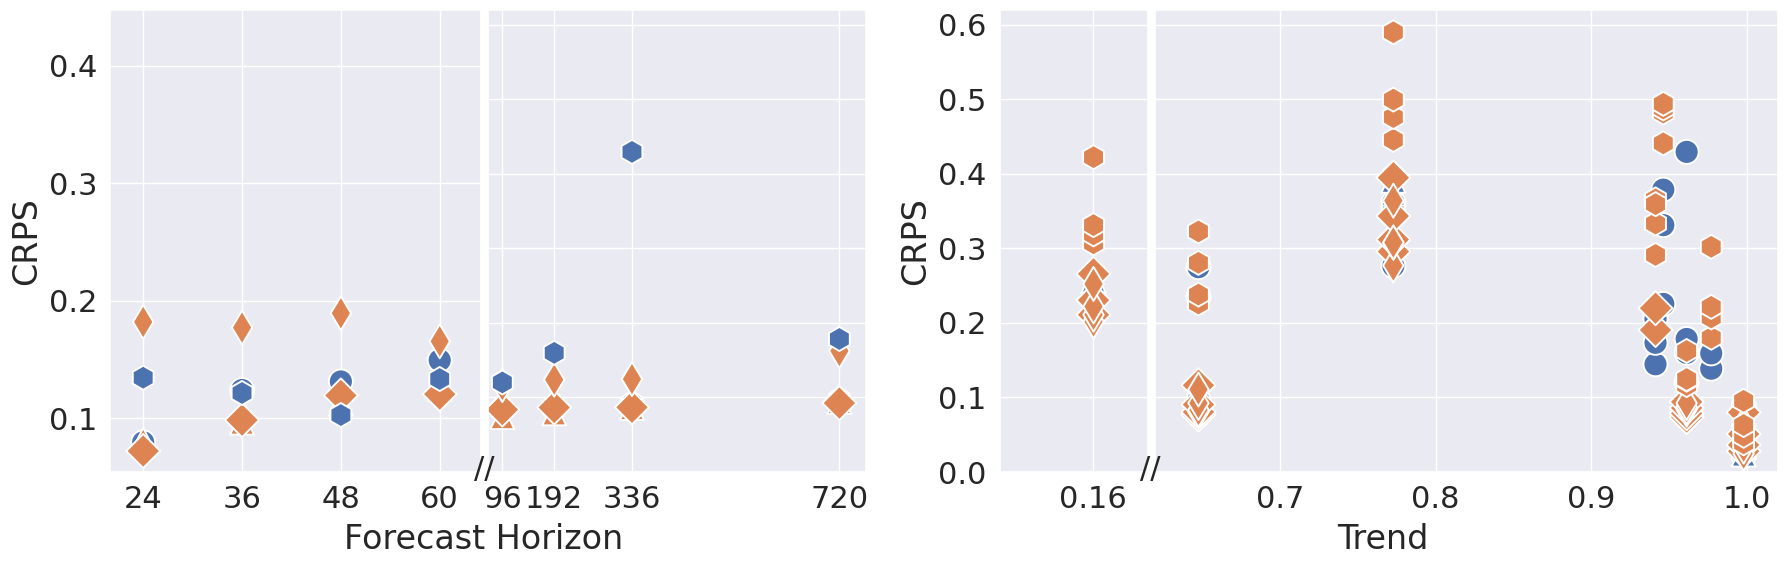

In [122]:
# grouped_df = sort_norm_res.groupby('Dataset')[].mean().reset_index()
# # grouped_df = sort_norm_res.groupby(['Horizon', 'Model']).agg({'Gap': 'mean', 'ReVIN': 'mean', 'Seasonality': 'mean', 'Trend': 'mean', 'Type': 'mean'}).reset_index()

sort_norm_res['Forecasting Horizon'] = sort_norm_res['Horizon'].astype(int)

# # grouped_df = sort_norm_res.groupby(['Model', 'Forecasting Horizon']).agg({'Gap': 'mean', 'CRPS': 'mean', 'Seasonality': 'mean', 'Trend': 'mean', 'Dataset':'mean'}).reset_index()



# grouped_df = sort_norm_res.groupby(['Model', 'Forecasting Horizon'])
# grouped_df = grouped_df.agg(['mean']).reset_index()  
# grouped_df.columns = long_nmae.columns.droplevel(1)


# plot_norm_scatter(grouped_df,x='Forecasting Horizon', y='CRPS', hue="Type", style='Model', size=None, hight=8, width=15)
# plot_norm_scatter(grouped_df,x='Seasonality', y='Trend', hue="CRPS", size="CRPS", hight=8, width=15)
# g = sns.scatterplot(data=df, x='Seasonality', y='Trend', hue="CRPS", size="CRPS", palette="coolwarm", sizes=(40, 1000),ax=ax2)

sort_norm_res = sort_norm_res[(sort_norm_res['dataset']=='ILI') | (sort_norm_res['dataset']=='Weather')]

plot_scatter(sort_norm_res)

## short

In [15]:
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips', 'wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_false/logs/"
norm_false_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_false_res['norm'] = 'None'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_true/logs/"
norm_true_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_true_res['norm'] = 'ReVIN'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_temp/logs/"
norm_temp_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_temp_res['norm'] = 'Scaling'

norm_res= pd.concat([norm_false_res, norm_true_res, norm_temp_res], ignore_index=True)

In [13]:
combined_df = pd.DataFrame()
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips', 'wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']
for scaler in ['identity', 'standard']:
    for revin in ['true', 'false']:
        for scaling in ['false', 'true']:
            norm_res = load_result(root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/abl_norm/{scaler}_revin_{revin}_scaling_{scaling}/logs/", verbose=False, models=['CSDI'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
            norm_res['scaler'] = scaler
            norm_res['revin'] = revin
            norm_res['scaling'] = scaling
            combined_df = pd.concat([combined_df, norm_res], ignore_index=True)
            
combined_df = reformat(combined_df)

In [14]:
norm_res = replace_dataset_name(combined_df)
norm_res['ND'] = norm_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
norm_res['CRPS'] = norm_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)
sort_norm_res = sort_norm_res[sort_norm_res["gobal norm"]=='identity']

In [17]:
pivot_table = pd.pivot_table(
    norm_res,
    values=['ND'],
    index=['dataset'],
    # columns=['model', 'norm'],
    columns=['norm'],
    aggfunc=lambda x: x.iloc[0]
)
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.reset_index()
pivot_table_formatted_md = pivot_table.to_markdown()

In [18]:
print(pivot_table_formatted_md)

|    | dataset            |   ND_None |   ND_ReVIN |   ND_Scaling |
|---:|:-------------------|----------:|-----------:|-------------:|
|  0 | electricity_nips   |  nan      |   nan      |       0.0657 |
|  1 | exchange_rate_nips |    0.0099 |     0.0109 |       0.0109 |
|  2 | solar_nips         |    1      |     0.5847 |       0.5832 |
|  3 | traffic_nips       |  nan      |     0.1731 |       0.1806 |


# Channel

In [9]:
datasets=None
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_false/logs/"
indep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
indep_res['channel'] = 'indep'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_true/logs/"
dep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
dep_res['channel'] = 'dep'

In [10]:
chennel_res= pd.concat([dep_res,indep_res], ignore_index=True)
chennel_res = replace_dataset_name(chennel_res)
sort_order_dict = {'pred hor.': ['96','192','336','720']}
sort_chennel_res = sort_order(chennel_res, sort_order_dict=sort_order_dict)

sort_chennel_res['ND'] = sort_chennel_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_chennel_res['CRPS'] = sort_chennel_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [11]:
# Create a pivot table
pivot_table = pd.pivot_table(
    sort_chennel_res,
    values=['CRPS'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'channel'],
    aggfunc=lambda x: x.iloc[0]
)
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.reset_index()
pivot_table_formatted_md = pivot_table.to_markdown()

/tmp/ipykernel_3845555/372056143.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(


In [12]:
print(pivot_table_formatted_md)

|    | dataset     |   pred hor. |   CRPS_DLinear_dep |   CRPS_DLinear_indep |   CRPS_PatchTST_dep |   CRPS_PatchTST_indep |
|---:|:------------|------------:|-------------------:|---------------------:|--------------------:|----------------------:|
|  0 | ETTh1       |          96 |             0.3334 |               0.329  |              0.3239 |                0.3212 |
|  1 | ETTh1       |         192 |             0.3611 |               0.4096 |              0.3609 |                0.3562 |
|  2 | ETTh1       |         336 |             0.3918 |               0.4177 |              0.3763 |                0.3737 |
|  3 | ETTh1       |         720 |             0.4266 |               0.4674 |              0.3882 |                0.3909 |
|  4 | ETTh2       |          96 |             0.3127 |               0.2034 |              0.1731 |                0.1746 |
|  5 | ETTh2       |         192 |             0.3351 |               0.2701 |              0.2001 |                0.2011 |


## short

In [33]:
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips','wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_false/logs/"
indep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
indep_res['channel'] = 'indep'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_true/logs/"
dep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
dep_res['channel'] = 'dep'

In [ ]:
chennel_res= pd.concat([dep_res,indep_res], ignore_index=True)
chennel_res = replace_dataset_name(chennel_res)

sort_chennel_res['ND'] = sort_chennel_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_chennel_res['CRPS'] = sort_chennel_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

# Missing baselines - LSTM

In [33]:
train_pred_len_list=['96', '192', '336', '720', '24','36','48','60']
train_context_list=['96', '36']

datasets=['ettm1','etth1','exchange_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/nn_baseline/logs/"
gru_res1 = load_result(root_dir=root_dir, verbose=False, models=['GRUForecaster'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
gru_res1 = replace_dataset_name(gru_res1)

datasets=['ettm2','etth2','weather_ltsf']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/nn_baseline_scale/logs/"
gru_res2 = load_result(root_dir=root_dir, verbose=False, models=['GRUForecaster'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
gru_res2 = replace_dataset_name(gru_res2)

gru_res = pd.concat([gru_res1, gru_res2], ignore_index=True)

long_crps = pd.read_csv("./exp_res/long_crps.csv")
long_nmae = pd.read_csv("./exp_res/long_nmae.csv")

In [34]:
new_res = gru_res.rename(columns={'dataset': 'Model', 'pred hor.': 'pred_len'})
new_res['pred_len'] = new_res['pred_len'].astype(str)

new_res['ND'] = new_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
new_res['CRPS'] = new_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [35]:
df_merged_nmae = long_nmae.copy()
df_merged_nmae['pred_len'] = df_merged_nmae['pred_len'].astype(str)

df_merged_crps = long_crps.copy()
df_merged_crps['pred_len'] = df_merged_crps['pred_len'].astype(str)


df_merged_crps = df_merged_crps.set_index(['Model', 'pred_len'])
df_merged_nmae = df_merged_nmae.set_index(['Model', 'pred_len'])
new_res = new_res.set_index(['Model', 'pred_len'])

In [36]:
combine_nmae_res = pd.merge(df_merged_nmae, new_res['ND'], left_index=True, right_index=True)
combine_nmae_res = combine_nmae_res.rename(columns={'ND': 'GRU'}).reset_index()

combine_crps_res = pd.merge(df_merged_crps, new_res['CRPS'], left_index=True, right_index=True)
combine_crps_res = combine_crps_res.rename(columns={'CRPS': 'GRU'}).reset_index()

In [37]:
combine_nmae_res.to_csv("./exp_res/update_long_nmae.csv", index=False)
combine_crps_res.to_csv("./exp_res/update_long_crps.csv", index=False)

# Computation Cost

In [2]:
def load_summary(root_dir, verbose=True, models=['ElasTST'], train_pred_len_list=['96-192-336-720'],train_context_list=['96'],datasets=None):
    dataset_list = []
    param_list = []
    mem_list = []
    train_time_list = []
    model_list = []
    if datasets is None:
        datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']

    seed=0
    
    for dataset in datasets:
        for model in models:
            for train_pred_len in train_pred_len_list:
                for train_context in train_context_list:
                    json_file = root_dir + f"{dataset}_{train_context}_{train_pred_len}_{model}_{seed}/summary.json"
                    
                    try:
                        with open(json_file, 'r') as file:
                            data = json.load(file)
                    except:
                        if verbose:
                            print("cannot find ", json_file) 
                        continue
                    
                    train_time = data['mean_train_batch_time']
                    trainable_parameters = data['trainable_parameters']
                    trainable_parameters_in_mb = trainable_parameters * 4 / (1024 ** 2)
                    train_mem_peak = data['memory_summary']['train']['mem_peak']
                    
                    dataset_list.append(dataset)
                    param_list.append(trainable_parameters_in_mb)
                    mem_list.append(train_mem_peak)
                    train_time_list.append(train_time)
                    model_list.append(model)



    res_dict = {"model":model_list, "dataset": dataset_list, 'NPARAMS (MB)': param_list, 'Max GPU Mem. (GB)': mem_list, "Avg. Train Time": train_time_list}

    return pd.DataFrame(res_dict)

def gpu_dataframe_to_markdown(df, filed='Max GPU Mem. (GB)'):
    # df.loc[:,'model'] = df['model'].replace('TransformerForecaster', 'Transformer', regex=True) 
    df.loc[:, filed] = df[filed].round(4)
    # df = df.pivot_table(index=['dataset'], columns='model', values=filed).reset_index()
    df = df.pivot_table(index=['dataset'], columns='model', values=filed, observed=False).reset_index()
    return df.to_markdown(index=False)

In [3]:
pred_len_list = ['96']
datasets = ['ettm1','electricity_ltsf', 'exchange_ltsf','weather_ltsf','traffic_ltsf']
root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/"
comp_budget = load_summary(root_dir, verbose=True, models=['PatchTST','DLinear','TimeGrad','GRU_NVP','CSDI'], train_pred_len_list=pred_len_list, datasets=datasets)

cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/electricity_ltsf_96_96_DLinear_0/summary.json
cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/weather_ltsf_96_96_CSDI_0/summary.json
cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/traffic_ltsf_96_96_CSDI_0/summary.json


In [4]:
comp_budget

,model,dataset,NPARAMS (MB),Max GPU Mem. (GB),Avg. Train Time
0,PatchTST,ettm1,5.141750,0.032442,0.029116
1,DLinear,ettm1,0.497341,0.018391,0.016629
2,TimeGrad,ettm1,1.133266,0.028333,0.039893
3,GRU_NVP,ettm1,1.008083,0.025000,0.032739
4,CSDI,ettm1,1.640350,0.147443,0.046746
5,PatchTST,electricity_ltsf,2.047001,0.047467,0.024961
6,TimeGrad,electricity_ltsf,3.310772,0.231849,0.036542
7,GRU_NVP,electricity_ltsf,3.509815,0.140491,0.021862
8,CSDI,electricity_ltsf,1.306679,0.286550,0.050155
9,PatchTST,exchange_ltsf,0.630341,0.018975,0.029638


In [5]:
# gpu_df = replace_dataset_name(combined_gpu_df)
gpu_markdown = gpu_dataframe_to_markdown(comp_budget, filed='Avg. Train Time')

In [6]:
print(gpu_markdown)

| dataset          |     CSDI |   DLinear |   GRU_NVP |   PatchTST |   TimeGrad |
|:-----------------|---------:|----------:|----------:|-----------:|-----------:|
| electricity_ltsf |   0.0502 |  nan      |    0.0219 |     0.025  |     0.0365 |
| ettm1            |   0.0467 |    0.0166 |    0.0327 |     0.0291 |     0.0399 |
| exchange_ltsf    |   0.0482 |    0.0171 |    0.0244 |     0.0296 |     0.0387 |
| traffic_ltsf     | nan      |    0.01   |    0.0358 |     0.0259 |     0.0367 |
| weather_ltsf     | nan      |    0.0094 |    0.0354 |     0.0259 |     0.0427 |
